## Importing Libraries

In [46]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve

from xgboost import XGBRegressor

from feature_engine.datetime import DatetimeFeatures 

import joblib
import matplotlib.pyplot as plt

## Display settings

In [3]:
pd.set_option("display.max_columns",None)

In [4]:
sklearn.set_config(transform_output="pandas")

## Loading data

In [6]:
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/validation.csv")
test_df = pd.read_csv("data/test.csv")

In [7]:
train_df

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Air India,2019-06-03,Delhi,Cochin,13:15:00,09:25:00,1210,2.0,No Info,10467
1,Jet Airways,2019-05-27,Delhi,Cochin,19:15:00,04:25:00,550,1.0,In-flight meal not included,12898
2,Jet Airways,2019-05-21,Kolkata,Banglore,06:30:00,19:50:00,800,1.0,No Info,14781
3,Jet Airways,2019-05-18,Delhi,Cochin,11:00:00,14:15:00,195,0.0,No Info,9564
4,Air India,2019-05-15,Kolkata,Banglore,14:15:00,16:45:00,150,0.0,No Info,5510
...,...,...,...,...,...,...,...,...,...,...
6690,Spicejet,2019-06-24,Kolkata,Banglore,17:10:00,19:40:00,150,0.0,No Info,3873
6691,Multiple Carriers,2019-06-15,Delhi,Cochin,10:20:00,19:15:00,535,1.0,No Info,9526
6692,Indigo,2019-04-21,Delhi,Cochin,02:00:00,07:45:00,345,1.0,No Info,6258
6693,Jet Airways,2019-03-24,Kolkata,Banglore,21:10:00,08:10:00,660,1.0,In-flight meal not included,11134


## Splitting the data

In [8]:
def split_data(data):
    X = data.drop(columns="price")
    y = data.price.copy()
    return (X,y)

In [9]:
X_train, y_train = split_data(train_df)

In [10]:
X_val, y_val = split_data(val_df)

In [11]:
X_test, y_test = split_data(test_df)

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6695 entries, 0 to 6694
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          6695 non-null   object 
 1   date_of_journey  6695 non-null   object 
 2   source           6695 non-null   object 
 3   destination      6695 non-null   object 
 4   dep_time         6695 non-null   object 
 5   arrival_time     6695 non-null   object 
 6   duration         6695 non-null   int64  
 7   total_stops      6695 non-null   float64
 8   additional_info  6695 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 470.9+ KB


## Data preprocessing

In [16]:
num_columns = ["duration","total_stops"]

dt_columns = ["date_of_journey","dep_time","arrival_time"]

cat_columns = [col for col in X_train.columns if (col not in num_columns) and (col not in dt_columns)]
cat_columns

['airline', 'source', 'destination', 'additional_info']

In [85]:
num_transformer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="median")),
    ("scaler",StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("encoder",OneHotEncoder(sparse_output=False,handle_unknown="ignore"))
])

doj_transformer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("extractor",DatetimeFeatures(features_to_extract=["month","week","day_of_week","day_of_month"],format="mixed")),
    ("scaler",StandardScaler())
])

time_transformer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("extractor",DatetimeFeatures(features_to_extract=["hour","minute"],format="mixed")),
    ("scaler",StandardScaler())
])


In [86]:
preprocessor = ColumnTransformer(transformers=[
("num",num_transformer,num_columns),
    ("cat",cat_transformer,cat_columns),
    ("doj",doj_transformer,["date_of_journey"]),
    ("time",time_transformer,["dep_time","arrival_time"])    
])

In [87]:
preprocessor.fit_transform(X_train)

,num__duration,num__total_stops,cat__airline_Air Asia,cat__airline_Air India,cat__airline_Goair,cat__airline_Indigo,cat__airline_Jet Airways,cat__airline_Multiple Carriers,cat__airline_Spicejet,cat__airline_Trujet,cat__airline_Vistara,cat__source_Banglore,cat__source_Chennai,cat__source_Delhi,cat__source_Kolkata,cat__source_Mumbai,cat__destination_Banglore,cat__destination_Cochin,cat__destination_Delhi,cat__destination_Hyderabad,cat__destination_Kolkata,cat__destination_New Delhi,cat__additional_info_1 Long layover,cat__additional_info_1 Short layover,cat__additional_info_2 Long layover,cat__additional_info_Business class,cat__additional_info_Change airports,cat__additional_info_In-flight meal not included,cat__additional_info_No Info,cat__additional_info_No check-in baggage included,cat__additional_info_Red-eye flight,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_month,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute
0,1.153882,1.817299,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.122609,0.887505,-1.454226,-1.234502,0.095017,-0.505749,-0.631500,0.023633
1,-0.161672,0.299861,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.261784,0.696308,-1.454226,1.586474,1.137588,-0.505749,-1.357767,0.023633
2,0.336644,0.299861,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.261784,0.505110,-0.957565,0.881230,-1.121315,0.286357,0.821035,1.542080
3,-0.869280,-1.217576,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.261784,0.313912,1.029078,0.528608,-0.252506,-1.297856,0.094767,-0.583746
4,-0.958977,-1.217576,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.261784,0.313912,-0.460904,0.175986,0.268779,-0.505749,0.385274,1.238390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,-0.958977,-1.217576,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.122609,1.461098,-1.454226,1.233852,0.790064,-0.769785,0.821035,0.934701
6691,-0.191571,0.299861,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.122609,1.078703,1.029078,0.175986,-0.426268,-0.241714,0.821035,-0.583746
6692,-0.570291,0.299861,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.599042,-0.450878,1.525739,0.881230,-1.816362,-1.297856,-0.922007,1.238390
6693,0.057587,0.299861,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.459867,-1.215668,1.525739,1.233852,1.485111,-0.769785,-0.776753,-0.887435


## Model Selection

In [88]:
algorithms = {
    "Linear Regression": LinearRegression(),
    "Support Vector Machine": SVR(),
    "Random Forest": RandomForestRegressor(n_estimators=10),
    "XG Boost": XGBRegressor(n_estimators=10)
}

In [89]:
data = pd.concat([train_df,val_df], axis=0)

X_data,y_data = split_data(data)
print(X_data.shape,y_data.shape)

(8369, 9) (8369,)


In [90]:
def plot_curves(sizes,mean_scores,std_scores,label,ax):
    ax.plot(
        sizes,
        mean_scores,
        marker="o",
        label=label
    )

    ax.fill_between(
        x=sizes,
        y1=mean_scores - std_scores,
        y2=mean_scores + std_scores,
        alpha=0.5
    )

In [106]:
def plot_learning_curves(name,algorithm,figsize=(12,4)):
    model = Pipeline(steps=[
        ("pre",preprocessor),
        ("alg",algorithm)
    ])
    
    train_sizes,train_scores,test_scores = learning_curve(
        estimator=model,
        X=X_data,
        y=y_data,
        cv=3,
        scoring="r2",
        n_jobs=-1,
        random_state=9
    )
    
    mean_train_scores = np.mean(train_scores,axis=1)
    std_train_scores = np.std(train_scores,axis=1)
    train_score = f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"
    
    mean_test_scores = np.mean(test_scores,axis=1)
    std_test_scores = np.std(test_scores,axis=1)
    test_score = f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"
    fig,ax = plt.subplots(figsize=figsize)
    
    #training curve
    plot_curves(
        train_sizes,
        mean_train_scores,
        std_train_scores,
        f"Train ({train_score})",
        ax
    )

    #testing curve
    plot_curves(
        train_sizes,
        mean_test_scores,
        std_test_scores,
        f"Test ({test_score})",
        ax
    )

    ax.set(xlabel="Training Set Size",ylabel="R-square",title=name)
    ax.legend(loc="lower right")

    plt.show()

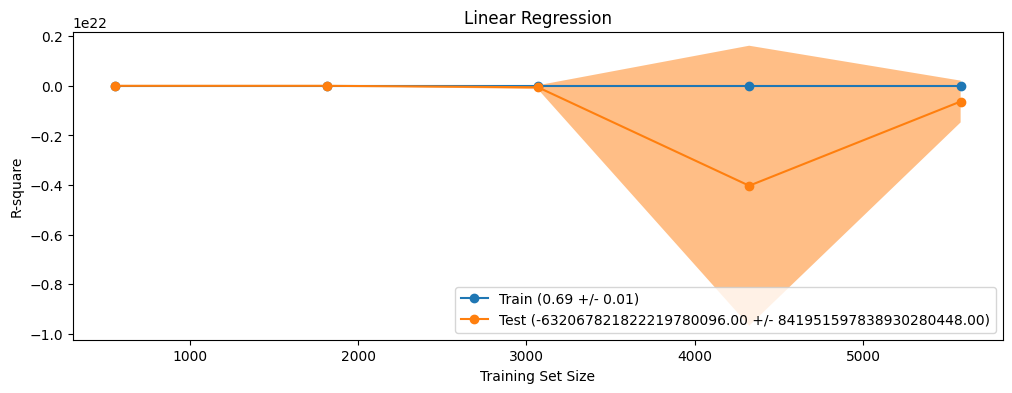

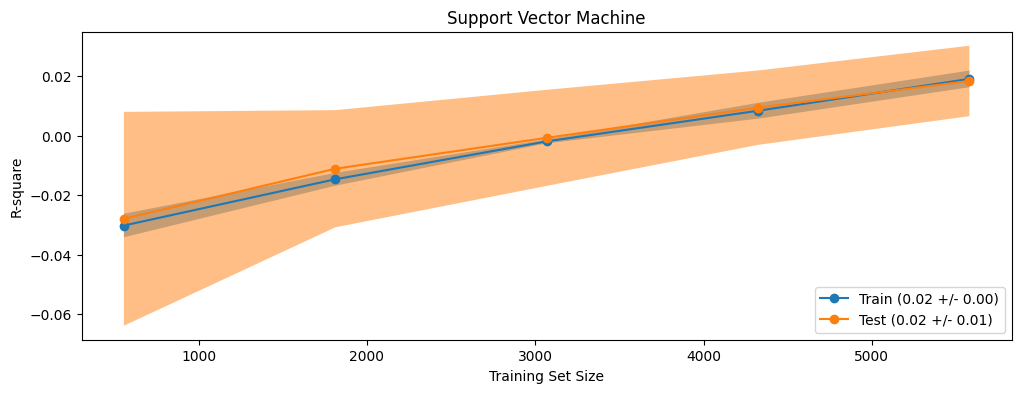

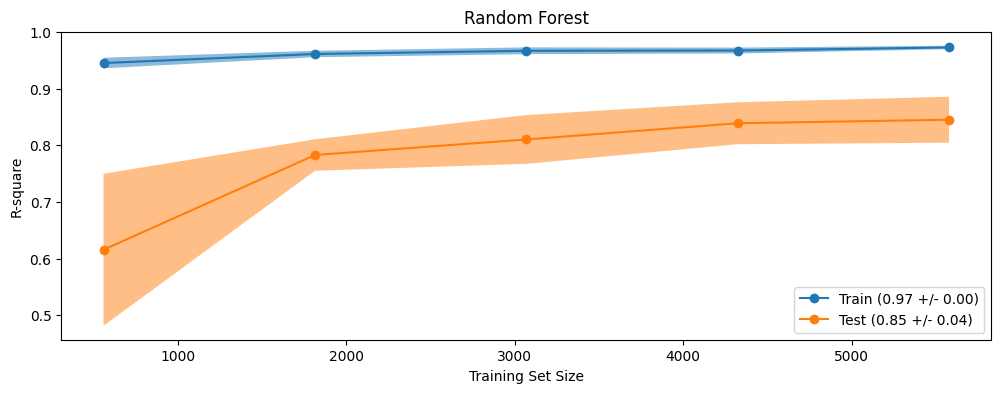

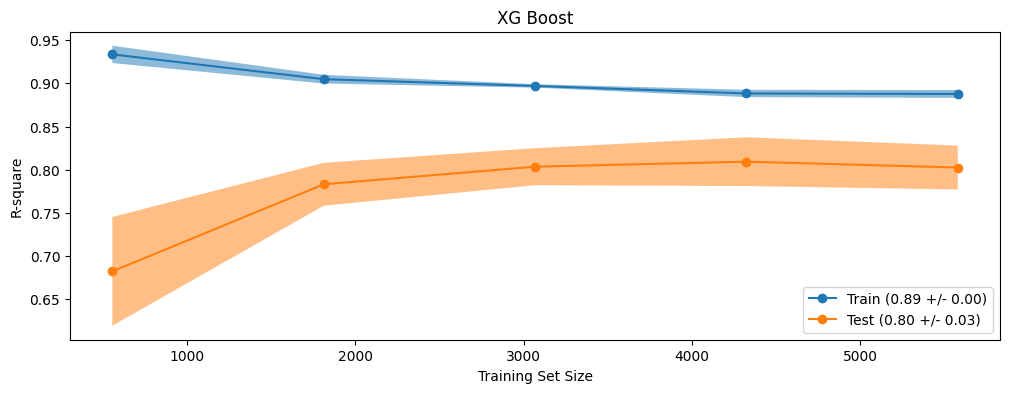

In [107]:
for name,alg in algorithms.items():
    plot_learning_curves(name,alg)    

In [108]:
print(train_df.shape)
print(val_df.shape)


(6695, 10)
(1674, 10)


In [109]:
print(X_data.isna().sum())

airline            0
date_of_journey    0
source             0
destination        0
dep_time           0
arrival_time       0
duration           0
total_stops        1
additional_info    0
dtype: int64


In [110]:
print(y_data.isna().sum())

0


## Model Training

In [111]:
model = Pipeline(steps=[
    ("pre",preprocessor),
    ("random forest",RandomForestRegressor(n_estimators=10))
])

In [112]:
model.fit(X_data,y_data)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('random forest', RandomForestRegressor(n_estimators=10))])

## Model Evaluation

In [113]:
def evaluate_model(X,y):
    y_pred = model.predict(X)
    return r2_score(y,y_pred)

In [114]:
print(f"R2 score on Training data is = {evaluate_model(X_data,y_data):.2f}")

R2 score on Training data is = 0.97


In [115]:
print(f"R2 score on Test data is = {evaluate_model(X_test,y_test):.2f}")

R2 score on Test data is = 0.87


## Model Persistence

In [116]:
joblib.dump(model,"random-forest-model.joblib")

['random-forest-model.joblib']

In [117]:
saved_model = joblib.load("random-forest-model.joblib")
saved_model

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('random forest', RandomForestRegressor(n_estimators=10))])

In [118]:
y_pred = saved_model.predict(X_test)
r2_score(y_test,y_pred)

0.8678121992325254